Importing Libraries

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [16]:
# Paths
positive = 'train/pos'
negative = 'train/neg'

X_text = []
y = []

# Load positive reviews (first 300)
for filename in sorted(os.listdir(positive))[:300]:
    filepath = os.path.join(positive, filename)
    with open(filepath, encoding='utf-8') as file:
        X_text.append(file.read())
        y.append(1)

# Load negative reviews (first 300)
for filename in sorted(os.listdir(negative))[:300]:
    filepath = os.path.join(negative, filename)
    with open(filepath, encoding='utf-8') as file:
        X_text.append(file.read())
        y.append(0)

print(f"Loaded {len(X_text)} reviews.")


Loaded 600 reviews.


Vectorize the text into TF-IDF features

In [17]:
vectorizer = TfidfVectorizer(max_features=100)
X_vec = vectorizer.fit_transform(X_text)

print(f"TF-IDF shape: {X_vec.shape}")

TF-IDF shape: (600, 100)


In [18]:
#split the data into training and validation sets 80/20
X_train, X_val, y_train_split, y_val_split = train_test_split(
    X_vec, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}")
print(f"Val shape: {X_val.shape}")


Train shape: (480, 100)
Val shape: (120, 100)


In [19]:
#Define Feature Transformations
# Apply PCA to reduce TF-IDF dimensions
pca = PCA(n_components=20, random_state=42)
X_train_pca = pca.fit_transform(X_train.toarray())
X_val_pca = pca.transform(X_val.toarray())

print(f"PCA-reduced shape: {X_train_pca.shape}")


PCA-reduced shape: (480, 20)


In [20]:
#polynomial
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_poly = poly.fit_transform(X_train.toarray())
X_val_poly = poly.transform(X_val.toarray())

print(f"Polynomial-expanded shape: {X_train_poly.shape}")


Polynomial-expanded shape: (480, 5051)


In [21]:
#PCA + Polynomial transformation
X_train_pca_poly = poly.fit_transform(X_train_pca)
X_val_pca_poly = poly.transform(X_val_pca)

print(f"PCA + Polynomial-expanded shape: {X_train_pca_poly.shape}")


PCA + Polynomial-expanded shape: (480, 211)


In [22]:
#Graphing function for visuals
def plot_performance(df_results, param_name, model_name, transformation_name):
    plt.plot(df_results[param_name], df_results['Validation Accuracy'], marker='o')
    plt.xscale('log')
    plt.xlabel(param_name)
    plt.ylabel('Validation Accuracy')
    plt.title(f'{model_name} ({transformation_name})')
    plt.grid(True)
    plt.show()


Logistic Regression - Original TF-IDF (Baseline)


,C,Train Accuracy,Validation Accuracy,Precision,Recall,F1 Score
0,0.001,0.693750,0.616667,0.594595,0.733333,0.656716
1,0.010,0.720833,0.616667,0.600000,0.700000,0.646154
2,0.100,0.733333,0.616667,0.606061,0.666667,0.634921
3,1.000,0.789583,0.641667,0.644068,0.633333,0.638655
4,10.000,0.802083,0.625000,0.631579,0.600000,0.615385
5,100.000,0.816667,0.616667,0.620690,0.600000,0.610169


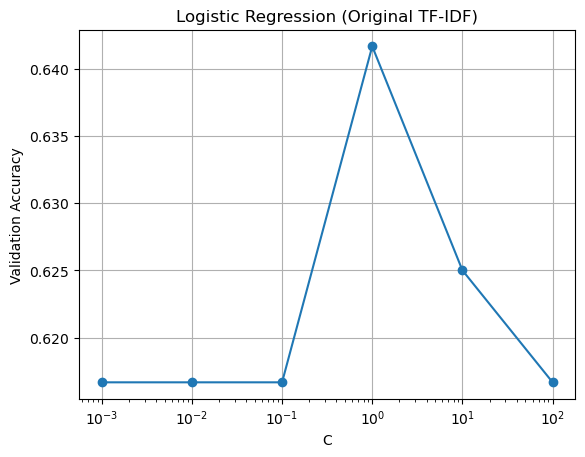

Logistic Regression - PCA


,C,Train Accuracy,Validation Accuracy,Precision,Recall,F1 Score
0,0.001,0.675000,0.633333,0.629032,0.650000,0.639344
1,0.010,0.672917,0.633333,0.629032,0.650000,0.639344
2,0.100,0.693750,0.633333,0.625000,0.666667,0.645161
3,1.000,0.706250,0.666667,0.672414,0.650000,0.661017
4,10.000,0.729167,0.675000,0.690909,0.633333,0.660870
5,100.000,0.725000,0.675000,0.690909,0.633333,0.660870


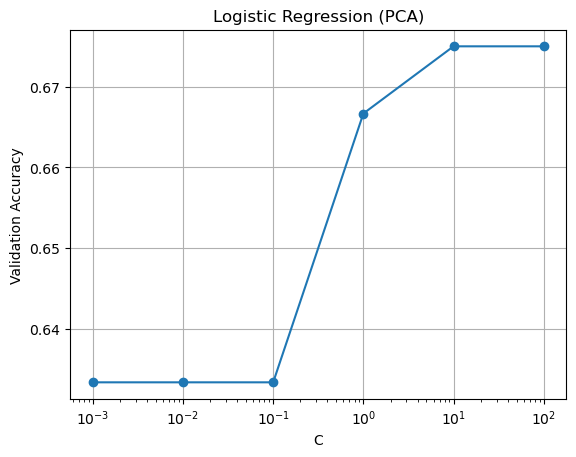

Logistic Regression - Polynomial


,C,Train Accuracy,Validation Accuracy,Precision,Recall,F1 Score
0,0.001,0.725000,0.608333,0.591549,0.700000,0.641221
1,0.010,0.731250,0.616667,0.602941,0.683333,0.640625
2,0.100,0.766667,0.641667,0.634921,0.666667,0.650407
3,1.000,0.818750,0.633333,0.637931,0.616667,0.627119
4,10.000,0.906250,0.641667,0.644068,0.633333,0.638655
5,100.000,0.995833,0.641667,0.644068,0.633333,0.638655


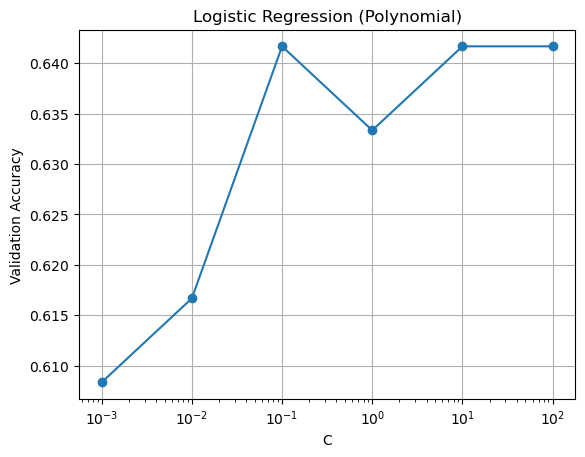

Logistic Regression - PCA + Polynomial


,C,Train Accuracy,Validation Accuracy,Precision,Recall,F1 Score
0,0.001,0.681250,0.625000,0.619048,0.650000,0.634146
1,0.010,0.681250,0.625000,0.615385,0.666667,0.640000
2,0.100,0.695833,0.633333,0.625000,0.666667,0.645161
3,1.000,0.716667,0.666667,0.666667,0.666667,0.666667
4,10.000,0.758333,0.683333,0.703704,0.633333,0.666667
5,100.000,0.827083,0.675000,0.705882,0.600000,0.648649


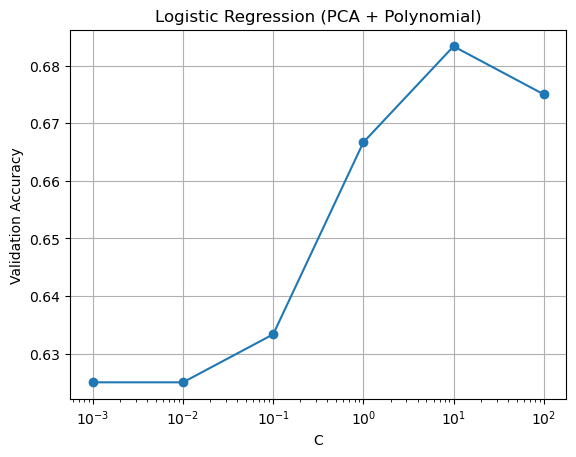

In [23]:
#LOGISITIC REGRESSION
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

def train_logistic_regression(X_train_data, X_val_data, y_train_split, y_val_split, transformation_name):
    results = []
    
    for C in C_values:
        model = LogisticRegression(C=C, max_iter=1000, solver='liblinear')
        model.fit(X_train_data, y_train_split)

        y_train_pred = model.predict(X_train_data)
        y_val_pred = model.predict(X_val_data)

        results.append({
            'C': C,
            'Train Accuracy': accuracy_score(y_train_split, y_train_pred),
            'Validation Accuracy': accuracy_score(y_val_split, y_val_pred),
            'Precision': precision_score(y_val_split, y_val_pred),
            'Recall': recall_score(y_val_split, y_val_pred),
            'F1 Score': f1_score(y_val_split, y_val_pred)
        })

    df_results = pd.DataFrame(results)
    display(df_results)
    plot_performance(df_results, 'C', 'Logistic Regression', transformation_name)
    return df_results

print("Logistic Regression - Original TF-IDF (Baseline)")
df_logreg_orig = train_logistic_regression(X_train, X_val, y_train_split, y_val_split, "Original TF-IDF")

print("Logistic Regression - PCA")
df_logreg_pca = train_logistic_regression(X_train_pca, X_val_pca, y_train_split, y_val_split, "PCA")

print("Logistic Regression - Polynomial")
df_logreg_poly = train_logistic_regression(X_train_poly, X_val_poly, y_train_split, y_val_split, "Polynomial")

print("Logistic Regression - PCA + Polynomial")
df_logreg_pca_poly = train_logistic_regression(X_train_pca_poly, X_val_pca_poly, y_train_split, y_val_split, "PCA + Polynomial")



SVM - Original TF-IDF (Baseline)


,C,Train Accuracy,Validation Accuracy,Precision,Recall,F1 Score
0,0.001,0.718750,0.616667,0.600000,0.700000,0.646154
1,0.010,0.718750,0.616667,0.600000,0.700000,0.646154
2,0.100,0.718750,0.616667,0.600000,0.700000,0.646154
3,1.000,0.800000,0.633333,0.642857,0.600000,0.620690
4,10.000,0.820833,0.650000,0.650000,0.650000,0.650000
5,100.000,0.843750,0.600000,0.603448,0.583333,0.593220


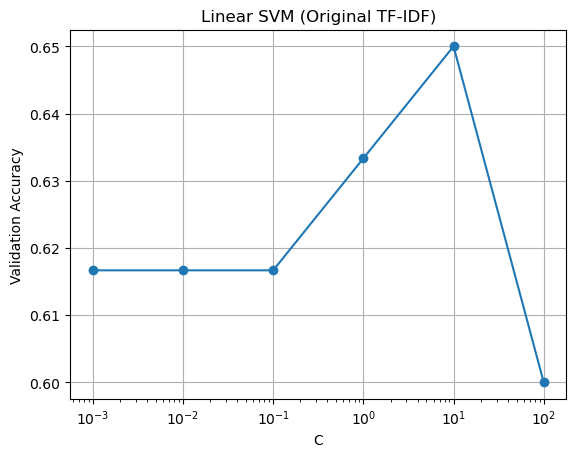

SVM - PCA


,C,Train Accuracy,Validation Accuracy,Precision,Recall,F1 Score
0,0.001,0.670833,0.616667,0.594595,0.733333,0.656716
1,0.010,0.670833,0.616667,0.594595,0.733333,0.656716
2,0.100,0.670833,0.616667,0.594595,0.733333,0.656716
3,1.000,0.710417,0.658333,0.672727,0.616667,0.643478
4,10.000,0.727083,0.666667,0.678571,0.633333,0.655172
5,100.000,0.710417,0.691667,0.701754,0.666667,0.683761


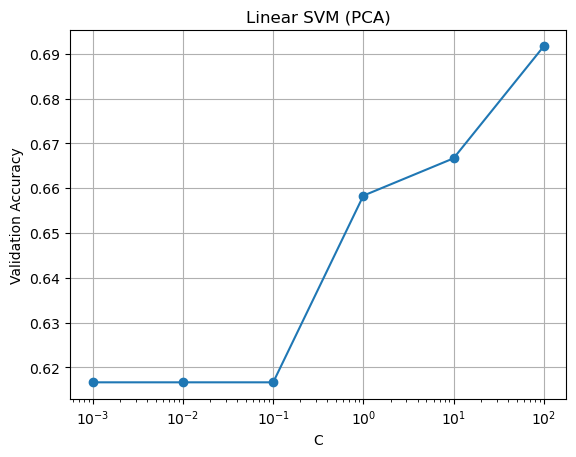

SVM - Polynomial


,C,Train Accuracy,Validation Accuracy,Precision,Recall,F1 Score
0,0.001,0.729167,0.608333,0.594203,0.683333,0.635659
1,0.010,0.729167,0.608333,0.594203,0.683333,0.635659
2,0.100,0.743750,0.633333,0.633333,0.633333,0.633333
3,1.000,0.835417,0.641667,0.649123,0.616667,0.632479
4,10.000,0.958333,0.633333,0.629032,0.650000,0.639344
5,100.000,1.000000,0.641667,0.654545,0.600000,0.626087


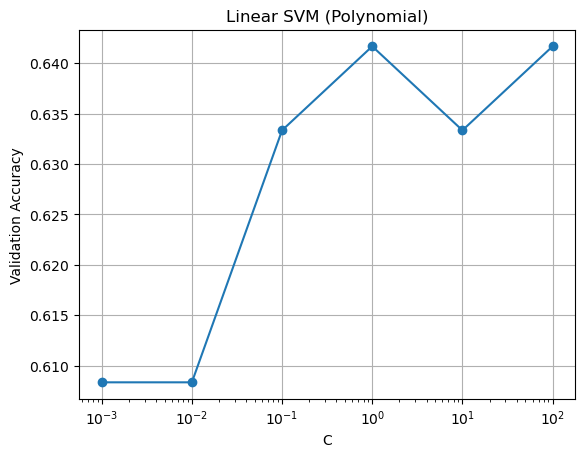

SVM - PCA + Polynomial


,C,Train Accuracy,Validation Accuracy,Precision,Recall,F1 Score
0,0.001,0.672917,0.616667,0.592105,0.750000,0.661765
1,0.010,0.672917,0.616667,0.592105,0.750000,0.661765
2,0.100,0.672917,0.616667,0.592105,0.750000,0.661765
3,1.000,0.722917,0.658333,0.661017,0.650000,0.655462
4,10.000,0.768750,0.658333,0.666667,0.633333,0.649573
5,100.000,0.858333,0.650000,0.655172,0.633333,0.644068


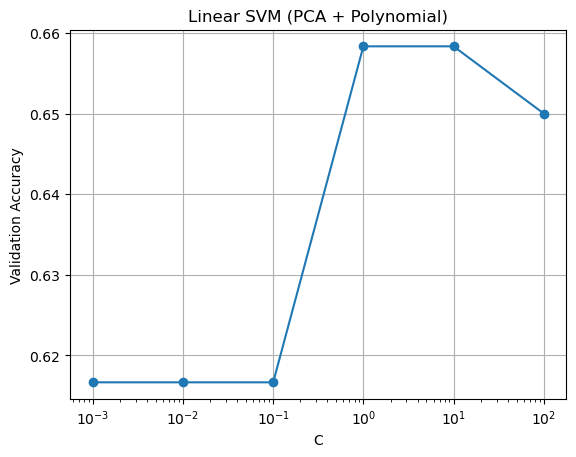

In [24]:
#SVM
def train_svm(X_train_data, X_val_data, y_train_split, y_val_split, transformation_name):
    results = []
    
    for C in C_values:
        model = SVC(C=C, kernel='linear')
        model.fit(X_train_data, y_train_split)

        y_train_pred = model.predict(X_train_data)
        y_val_pred = model.predict(X_val_data)

        results.append({
            'C': C,
            'Train Accuracy': accuracy_score(y_train_split, y_train_pred),
            'Validation Accuracy': accuracy_score(y_val_split, y_val_pred),
            'Precision': precision_score(y_val_split, y_val_pred),
            'Recall': recall_score(y_val_split, y_val_pred),
            'F1 Score': f1_score(y_val_split, y_val_pred)
        })

    df_results = pd.DataFrame(results)
    display(df_results)
    plot_performance(df_results, 'C', 'Linear SVM', transformation_name)
    return df_results

print("SVM - Original TF-IDF (Baseline)")
df_svm_orig = train_svm(X_train, X_val, y_train_split, y_val_split, "Original TF-IDF")

print("SVM - PCA")
df_svm_pca = train_svm(X_train_pca, X_val_pca, y_train_split, y_val_split, "PCA")

print("SVM - Polynomial")
df_svm_poly = train_svm(X_train_poly, X_val_poly, y_train_split, y_val_split, "Polynomial")

print("SVM - PCA + Polynomial")
df_svm_pca_poly = train_svm(X_train_pca_poly, X_val_pca_poly, y_train_split, y_val_split, "PCA + Polynomial")



Neural Network - Original TF-IDF (Baseline)


,Hidden Layer Size,Train Accuracy,Validation Accuracy,Precision,Recall,F1 Score
0,50,1.0,0.650000,0.655172,0.633333,0.644068
1,100,1.0,0.658333,0.655738,0.666667,0.661157
2,150,1.0,0.666667,0.666667,0.666667,0.666667
3,200,1.0,0.666667,0.678571,0.633333,0.655172
4,300,1.0,0.650000,0.655172,0.633333,0.644068
5,400,1.0,0.658333,0.666667,0.633333,0.649573


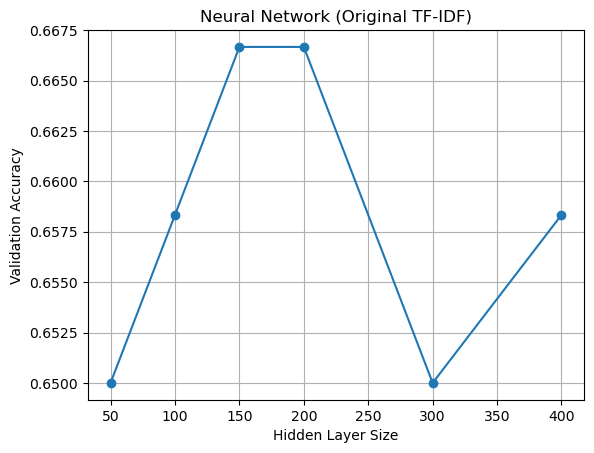

Neural Network - PCA


c:\Users\josep\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


,Hidden Layer Size,Train Accuracy,Validation Accuracy,Precision,Recall,F1 Score
0,50,0.966667,0.691667,0.694915,0.683333,0.689076
1,100,0.997917,0.708333,0.704918,0.716667,0.710744
2,150,1.000000,0.691667,0.688525,0.700000,0.694215
3,200,1.000000,0.650000,0.655172,0.633333,0.644068
4,300,1.000000,0.691667,0.701754,0.666667,0.683761
5,400,1.000000,0.691667,0.709091,0.650000,0.678261


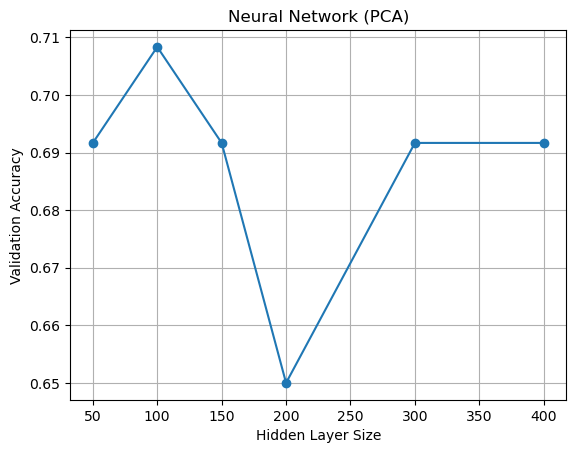

Neural Network - Polynomial


,Hidden Layer Size,Train Accuracy,Validation Accuracy,Precision,Recall,F1 Score
0,50,1.0,0.633333,0.637931,0.616667,0.627119
1,100,1.0,0.633333,0.637931,0.616667,0.627119
2,150,1.0,0.633333,0.637931,0.616667,0.627119
3,200,1.0,0.641667,0.644068,0.633333,0.638655
4,300,1.0,0.641667,0.644068,0.633333,0.638655
5,400,1.0,0.633333,0.637931,0.616667,0.627119


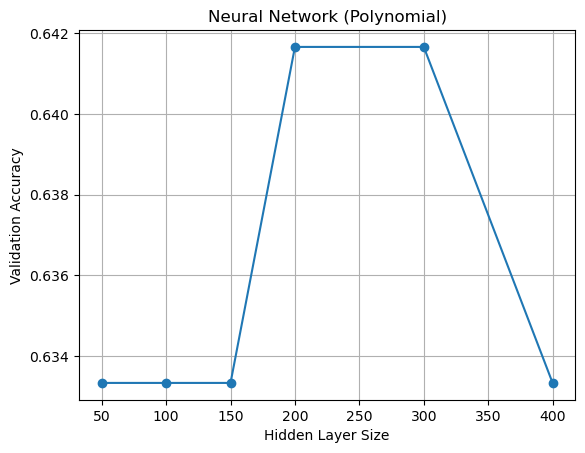

Neural Network - PCA + Polynomial


,Hidden Layer Size,Train Accuracy,Validation Accuracy,Precision,Recall,F1 Score
0,50,0.993750,0.733333,0.750000,0.700000,0.724138
1,100,0.997917,0.750000,0.750000,0.750000,0.750000
2,150,1.000000,0.758333,0.754098,0.766667,0.760331
3,200,1.000000,0.741667,0.754386,0.716667,0.735043
4,300,1.000000,0.733333,0.741379,0.716667,0.728814
5,400,1.000000,0.750000,0.758621,0.733333,0.745763


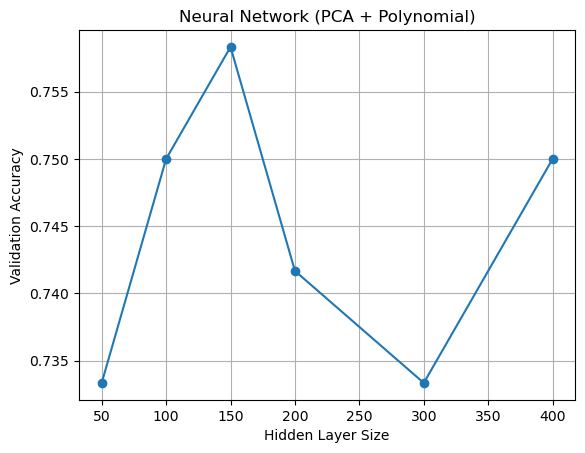

In [26]:
#NEURAL NETWORK
hidden_layer_sizes = [(50,), (100,), (150,), (200,), (300,), (400,)]

def train_nn(X_train_data, X_val_data, y_train_split, y_val_split, transformation_name):
    results = []
    
    for size in hidden_layer_sizes:
        model = MLPClassifier(hidden_layer_sizes=size, max_iter=2000, random_state=42)
        model.fit(X_train_data, y_train_split)

        y_train_pred = model.predict(X_train_data)
        y_val_pred = model.predict(X_val_data)

        results.append({
            'Hidden Layer Size': size[0],
            'Train Accuracy': accuracy_score(y_train_split, y_train_pred),
            'Validation Accuracy': accuracy_score(y_val_split, y_val_pred),
            'Precision': precision_score(y_val_split, y_val_pred),
            'Recall': recall_score(y_val_split, y_val_pred),
            'F1 Score': f1_score(y_val_split, y_val_pred)
        })

    df_results = pd.DataFrame(results)
    display(df_results)

    plt.plot(df_results['Hidden Layer Size'], df_results['Validation Accuracy'], marker='o')
    plt.xlabel('Hidden Layer Size')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Neural Network ({transformation_name})')
    plt.grid(True)
    plt.show()

    return df_results

print("Neural Network - Original TF-IDF (Baseline)")
df_nn_orig = train_nn(X_train, X_val, y_train_split, y_val_split, "Original TF-IDF")

print("Neural Network - PCA")
df_nn_pca = train_nn(X_train_pca, X_val_pca, y_train_split, y_val_split, "PCA")

print("Neural Network - Polynomial")
df_nn_poly = train_nn(X_train_poly, X_val_poly, y_train_split, y_val_split, "Polynomial")

print("Neural Network - PCA + Polynomial")
df_nn_pca_poly = train_nn(X_train_pca_poly, X_val_pca_poly, y_train_split, y_val_split, "PCA + Polynomial")


